In [35]:
#import the required libraries
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)
from sklearn.model_selection import train_test_split

In [36]:
#filename = this will be the pathway for the swahili and hindi datasets.
#This function is basically for taking in the contents of the dataset.
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [37]:
#This function is to split the text into swahili-english pairs and hindi-english pairs. This will help in translating English sentences(input) to Swahili/Hindi (output)
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [38]:
#So now, we are taking in a filename which will basically be the hindi or swahili dataset and we are splitting them as mentioned above.
data = read_text("swahili1.txt")
lang_eng = to_lines(data)
lang_eng


[['Any recent chills, night sweats or fever?',
  'Kuumwa , kutokwa majasho usiku au joto lolote hivi majuzi?',
  ' '],
 ['Have you gained or lost weight without trying?',
  'Je, umeongeza au kupunguza uzani bila kukusudia?',
  ' '],
 ['Have you been tired?', 'Je, umewahi kuchoka?', ''],
 ['Any dry or itchy areas?', 'Maeneo yoyote yaliyokauka au yanayowasha?', ''],
 ['Any rashes, bumps, or sores anywhere?',
  'Vipele, majipu au vidonda popote?',
  ''],
 ['Do you bruise easily?', 'Je, wewe huchibuka kwa urahisi?', ''],
 ['Have any of your moles changed in color, shape or size?Any changes in hair or nails?',
  'Je, magamba yako yamegeuka rangi, umbo au ukubwa? Je pamekuwa na mabadiliko katika nyweleau kucha zako?',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #2122391 (Pfirsichbaeumchen)'],
 ['Have you had any dizziness (room spinning) or light-headedness?',
  'Umewahi kuwa na kisuunzi (kizunguzungu) au kichwa kuwa kizito?',
  ''],
 ['Have you fainted or passed out?', '

In [39]:
#Have the text which was read be in array form. This will help us to utilize the data better in the next steps.
lang_eng = array(lang_eng)

In [40]:
lang_eng

array([['Any recent chills, night sweats or fever?',
        'Kuumwa , kutokwa majasho usiku au joto lolote hivi majuzi?',
        ' '],
       ['Have you gained or lost weight without trying?',
        'Je, umeongeza au kupunguza uzani bila kukusudia?', ' '],
       ['Have you been tired?', 'Je, umewahi kuchoka?', ''],
       ['Any dry or itchy areas?',
        'Maeneo yoyote yaliyokauka au yanayowasha?', ''],
       ['Any rashes, bumps, or sores anywhere?',
        'Vipele, majipu au vidonda popote?', ''],
       ['Do you bruise easily?', 'Je, wewe huchibuka kwa urahisi?', ''],
       ['Have any of your moles changed in color, shape or size?Any changes in hair or nails?',
        'Je, magamba yako yamegeuka rangi, umbo au ukubwa? Je pamekuwa na mabadiliko katika nyweleau kucha zako?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #2122391 (Pfirsichbaeumchen)'],
       ['Have you had any dizziness (room spinning) or light-headedness?',
        'Umewahi kuwa na 

In [41]:
#Will use 50 lines from the dataset for the training part. 
lang_eng = lang_eng[:50,:]

In [42]:
#this gets rid of punctuations and has the text be lowercase. All of this is done to clean data.
lang_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in lang_eng[:,0]]
lang_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in lang_eng[:,1]]
for i in range(len(lang_eng)):
    lang_eng[i,0] = lang_eng[i,0].lower()
    lang_eng[i,1] = lang_eng[i,1].lower()

In [43]:
lang_eng

array([['any recent chills night sweats or fever',
        'kuumwa  kutokwa majasho usiku au joto lolote hivi majuzi', ' '],
       ['have you gained or lost weight without trying',
        'je umeongeza au kupunguza uzani bila kukusudia', ' '],
       ['have you been tired', 'je umewahi kuchoka', ''],
       ['any dry or itchy areas',
        'maeneo yoyote yaliyokauka au yanayowasha', ''],
       ['any rashes bumps or sores anywhere',
        'vipele majipu au vidonda popote', ''],
       ['do you bruise easily', 'je wewe huchibuka kwa urahisi', ''],
       ['have any of your moles changed in color shape or sizeany changes in hair or nails',
        'je magamba yako yamegeuka rangi umbo au ukubwa je pamekuwa na mabadiliko katika nyweleau kucha zako',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #2122391 (Pfirsichbaeumchen)'],
       ['have you had any dizziness room spinning or lightheadedness',
        'umewahi kuwa na kisuunzi kizunguzungu au kichwa kuwa ki

In [44]:
#In the encoder-decoder algorithm, the input and output sentences have to be "tokenized" into integer sequences of fixed length.
#The Tokenizer() class provided by Keras will turn sequences for both the input and output (both the language and english part) into integer sequences. 
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [45]:
#This is to tokenize the english pairs.
eng_tokenizer = tokenization(lang_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 10
print('English Vocabulary Size: %d' % eng_vocab_size)


English Vocabulary Size: 168


In [46]:
#This is to tokenize the language part
lang_tokenizer = tokenization(lang_eng[:, 1])
lang_vocab_size = len(lang_tokenizer.word_index) + 1

lang_length = 10
print('Language Vocabulary Size: %d' % lang_vocab_size)

Language Vocabulary Size: 207


In [47]:
#This is the function for the encoder sequence. What is happening here is that the input sentence has been read and now will be encoded to a fixed length integer sequence (tokenized)
#padding is done with 0 values to have the sentences be the same maximum length.
def encode_sequences(tokenizer, length, lines):
         seq = tokenizer.texts_to_sequences(lines)
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [48]:
# Now it is time for the model building part. We first split data for training and testing. We have to train the model and use those observations to make predictions on the unseen data which is the testing data.
train, test = train_test_split(lang_eng, test_size=0.4, random_state = 12)

In [49]:
#Now we will use the function encode_sequences which was mentioned above. Input sequence would be the sentences for language and the target sequence would be english sentences.
#This has to be done for testing and training shown below.

trainX = encode_sequences(lang_tokenizer, lang_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
testX = encode_sequences(lang_tokenizer, lang_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [54]:
#Now, to build the model:
#The encoder part has the first/embedding layer and LSTM model.
#The decoder part has a LSTM model and dense layer which helps to return the output.
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [55]:
# Use the function from above to build the model
model = define_model(lang_vocab_size, eng_vocab_size, lang_length, eng_length, 512)

In [56]:
#RMSprop optimizer is used in the model with sparse categorical crossentropy as loss function.
#What will happen is that the target sequence will be as it is and we can use it like that. Otherwise, that target sequence could be changed by having a binary number for each integer value.
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [57]:
#Training the model now: As seen below, 80% of data is used to train the model. 20% is used to test the model and see if the predictions are good.

#What the ModelCheckpoint() function does is it saves the best model with the lowest validation loss.
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# trained model with 13 epochs, batch size of 80 with 20% of validation split, and lowest validation loss
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=40, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

/Users/saumyapandey/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 24 samples, validate on 6 samples
Epoch 1/30
24/24 [==============================] - 6s 251ms/step - loss: 5.1238 - val_loss: 5.0638

Epoch 00001: val_loss improved from inf to 5.06382, saving model to model.h1.24_jan_19
Epoch 2/30
24/24 [==============================] - 1s 34ms/step - loss: 5.0127 - val_loss: 4.5709

Epoch 00002: val_loss improved from 5.06382 to 4.57095, saving model to model.h1.24_jan_19
Epoch 3/30
24/24 [==============================] - 1s 27ms/step - loss: 4.4853 - val_loss: 5.0944

Epoch 00003: val_loss did not improve from 4.57095
Epoch 4/30
24/24 [==============================] - 1s 23ms/step - loss: 5.0191 - val_loss: 5.0173

Epoch 00004: val_loss did not improve from 4.57095
Epoch 5/30
24/24 [==============================] - 1s 33ms/step - loss: 4.8427 - val_loss: 4.8140

Epoch 00005: val_loss did not improve from 4.57095
Epoch 6/30
24/24 [==============================] - 1s 26ms/step - loss: 4.3827 - val_loss: 4.1483

Epoch 00006: val_loss imp

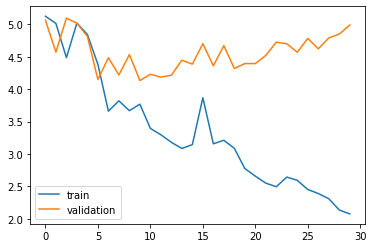

In [58]:
#Here the plot will be comparing training and validation loss. 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [59]:
#The predictions outputted are in the form of integer sequences since that's how it was encoded. We need the integer sequences to be returned as words it corresponds to.
#This is the function for it.
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [60]:
#We use the function from above to have the integer sequences be returned as words.
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [61]:
#We use the model which has the lowest validation loss and make predicitions on the testing data. 
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/Users/saumyapandey/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [62]:
#A format where we have the actual translation and predicted translations
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [63]:
# print 15 rows randomly to see some actual and predicted translations and how the model performs
pred_df.sample(15)

,actual,predicted
12,have you ever had rheumatic fever,
1,any belly acheabdominal pain,
0,any cough or phlegm production,
14,do you have any chest pains,
7,any heartburn,
4,have you ever been told you have a heart murmur,
2,have you had any dizziness room spinning or lightheadedness,
9,have you fainted or passed out,
6,any hoarseness,
3,any problems with leg swelling or varicose veins,


/Users/saumyapandey/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


,actual,predicted
9,have you fainted or passed out,
6,any hoarseness,
4,have you ever been told you have a heart murmur,
5,have you ever had tuberculosis,
2,have you had any dizziness room spinning or lightheadedness,
1,any belly acheabdominal pain,
19,any nausea vomiting cramping diarrhea,
12,have you ever had rheumatic fever,
3,any problems with leg swelling or varicose veins,
14,do you have any chest pains,
